In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.5 MB/s eta 0:00:00


In [6]:
from datetime import datetime
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

import statsmodels.api as sm
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import pmdarima as pm
from pmdarima.arima import auto_arima

In [3]:
# load dataset
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

# Load your dataset here
!wget https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv

df_beras = pd.read_csv('Beras.csv', header=0, index_col=0, parse_dates=True, date_parser=parser)

--2024-06-16 09:55:31--  https://raw.githubusercontent.com/Danazzz/dataset-beras-scm/master/csv/Beras.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42658 (42K) [text/plain]
Saving to: ‘Beras.csv’

Beras.csv           100%[===================>]  41.66K  --.-KB/s    in 0.04s   

2024-06-16 09:55:31 (1009 KB/s) - ‘Beras.csv’ saved [42658/42658]



<ipython-input-3-0fec2939f882>:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_beras = pd.read_csv('Beras.csv', header=0, index_col=0, parse_dates=True, date_parser=parser)


In [4]:
df_beras_trend = pd.DataFrame()
df_beras_seasonal = pd.DataFrame()
df_beras_resid = pd.DataFrame()

for series_name, series in df_beras.items():
  stl = STL(df_beras[series_name], period=12, robust=True)
  result = stl.fit()
  df_beras_trend[series_name] = result.trend
  df_beras_seasonal[series_name] = result.seasonal
  df_beras_resid[series_name] = result.resid

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
def split_data(dataset):
  train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)
  return train_data, test_data

train_trend, test_trend = split_data(df_beras_trend)
train_seasonal, test_seasonal = split_data(df_beras_seasonal)
train_resid, test_resid = split_data(df_beras_resid)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=2094.107, Time=20.10 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=2339.344, Time=0.88 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=2279.377, Time=3.20 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=2158.638, Time=7.84 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=2094.434, Time=18.65 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=2095.130, Time=4.00 sec
 ARIMA(2,2,2)(2,0,1)[4]             : AIC=2094.473, Time=25.73 sec
 ARIMA(2,2,2)(1,0,2)[4]             : AIC=2094.086, Time=30.34 sec
 ARIMA(2,2,2)(0,0,2)[4]             : AIC=2093.949, Time=11.48 sec
 ARIMA(1,2,2)(0,0,2)[4]             : AIC=2092.243, Time=21.33 sec
 ARIMA(1,2,2)(0,0,1)[4]             : AIC=2097.042, Time=8.68 sec
 ARIMA(1,2,2)(1,0,2)[4]             : AIC=2093.462, Time=27.62 sec
 ARIMA(1,2,2)(1,0,1)[4]             : AIC=2098.287, Time=13.47 sec
 ARIMA(0,2,2)(0,0,2)[4]             : AIC=2122.020, Time=12.57 sec
 ARIMA(1,2,1)(0,0,2)[4] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


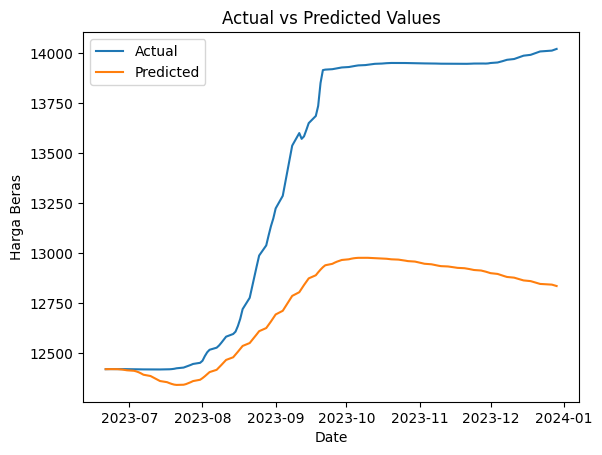

In [12]:
# Model Evaluation

# Fit a simple auto_arima model
def data_modelling(train, test):
  arima = pm.auto_arima(train['Harga Beras'],X=train.drop(columns=['Harga Beras']), d=2,error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf')

  # Print out summary information on the fit
  print(arima.summary())
  print(arima.params)



  pred=arima.predict(n_periods=136, X=test.drop(columns=['Harga Beras']), alpha=0.05)
  pred

  # plt.figure(figsize=(15,5))
  # plt.grid()
  # #plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
  # plt.plot(test['Harga Beras'], marker='o', label='Test')
  # plt.plot(pred, marker='v', label='Prediction')
  # plt.legend()
  # plt.xticks(rotation=90)
  # plt.show()
  # print("="*50)
  # print("="*50)
  # mape=mean_absolute_percentage_error(test['Harga Beras'], pred)
  # print("Mean Absolute Percentage Error", mape)
  # print("="*50)
  # mse=mean_squared_error(test['Harga Beras'], pred)
  # print("Mean Squared Error",mse)
  # print("="*50)
  # print("RMSE", (mse)**0.5)
  # print("="*50)
  # print("AIC values {}".format(arima.aic()))
  # print("="*50)
  # print("="*50)
  # print("="*50)
  # print("="*50)


  # a=pd.DataFrame(test['Harga Beras'])
  # a=a.reset_index()
  # a=a.drop(columns='index')
  # a

  # prediction=pd.DataFrame(pred)
  # prediction=prediction.reset_index()
  # prediction=prediction.drop(columns='index')
  # prediction
  # output=pd.DataFrame()
  # output['Test']=a['Harga Beras']
  # output['Prediction']=prediction[0]
  # output['Difference']=output['Test']-output['Prediction']
  # output['% Chnage']=abs(output['Difference']/output['Test'])*100
  # output

  plt.plot(test.index, test['Harga Beras'], label='Actual')

  # Plot the predicted values
  plt.plot(test.index, pred, label='Predicted')

  plt.title('Actual vs Predicted Values')
  plt.xlabel('Date')
  plt.ylabel('Harga Beras')
  plt.legend()

  plt.show()

  return pred

predict_trend = data_modelling(train_trend, test_trend)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=inf, Time=22.38 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=4653.915, Time=1.00 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=4357.719, Time=8.48 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=13.01 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=4363.956, Time=1.37 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=4339.870, Time=5.44 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=4142.891, Time=23.86 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=4358.417, Time=11.19 sec
 ARIMA(1,2,0)(2,0,2)[4]             : AIC=4081.293, Time=30.06 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=4262.653, Time=16.51 sec
 ARIMA(0,2,0)(2,0,2)[4]             : AIC=4549.849, Time=14.82 sec
 ARIMA(2,2,0)(2,0,2)[4]             : AIC=4015.154, Time=25.25 sec
 ARIMA(2,2,0)(1,0,2)[4]             : AIC=4214.457, Time=20.54 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=4276.720, Time=16.16 sec
 ARIMA(2,2,0)(1,0,1)[4]          

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


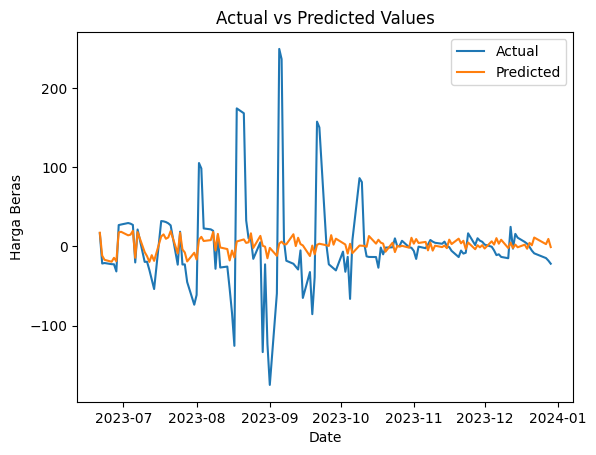

In [13]:
predict_seasonal = data_modelling(train_seasonal, test_seasonal)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=5678.433, Time=30.21 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6549.313, Time=0.92 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=6227.503, Time=2.31 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=2.98 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=inf, Time=15.45 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=inf, Time=14.40 sec
 ARIMA(2,2,2)(2,0,1)[4]             : AIC=inf, Time=18.37 sec
 ARIMA(2,2,2)(1,0,2)[4]             : AIC=5676.889, Time=33.66 sec
 ARIMA(2,2,2)(0,0,2)[4]             : AIC=inf, Time=29.69 sec
 ARIMA(2,2,2)(2,0,2)[4]             : AIC=inf, Time=25.11 sec
 ARIMA(1,2,2)(1,0,2)[4]             : AIC=inf, Time=9.22 sec
 ARIMA(2,2,1)(1,0,2)[4]             : AIC=inf, Time=3.13 sec
 ARIMA(3,2,2)(1,0,2)[4]             : AIC=inf, Time=11.46 sec
 ARIMA(2,2,3)(1,0,2)[4]             : AIC=inf, Time=27.13 sec
 ARIMA(1,2,1)(1,0,2)[4]             : AIC=inf, Time=4.58 sec
 ARIMA(1,2,3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


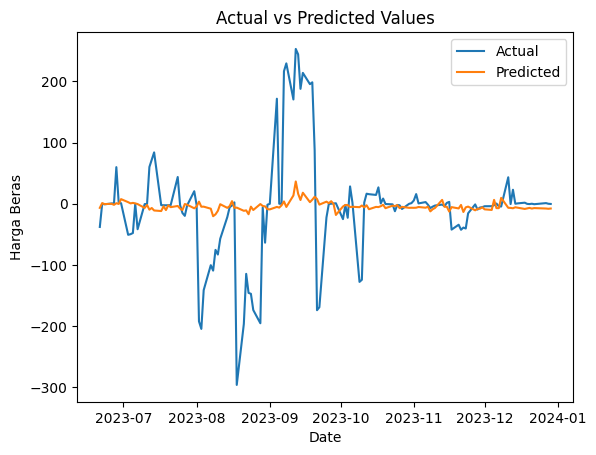

In [14]:
predict_resid = data_modelling(train_resid, test_resid)

In [15]:
train_data_asli, test_data_asli = train_test_split(df_beras, test_size=0.2, shuffle=False)

# Trend Metrics

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_trend, test_trend['Harga Beras'].values))
mae = mean_absolute_error(predict_trend,test_trend['Harga Beras'].values)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_trend,test_trend['Harga Beras'].values)

# Mean Magnitude of Relative Error
mmre = (abs((predict_trend - test_trend['Harga Beras'].values) / test_trend['Harga Beras'].values)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_trend - test_trend['Harga Beras'].values) / test_trend['Harga Beras'].values))

# Mean Magnitude of Error Relative
mmer = (abs(predict_trend - test_trend['Harga Beras'].values)).mean()

# Mean Square Error
mse = mean_squared_error(predict_trend, test_trend['Harga Beras'].values)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 782.5148014625836
Mean Absolute Error: 649.3451037374921
R Square: -9.6603
Mean Magnitude of Relative Error: 0.0470
Median Magnitude of Relative Error: 0.0689
Mean Magnitude of Error Relative:  649.3451037374921
Mean Square Error: 612329.4145080266


# Seasonal Metrics

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_seasonal, test_seasonal['Harga Beras'].values))
mae = mean_absolute_error(predict_seasonal,test_seasonal['Harga Beras'].values)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_seasonal,test_seasonal['Harga Beras'].values)

# Mean Magnitude of Relative Error
mmre = (abs((predict_seasonal - test_seasonal['Harga Beras'].values) / test_seasonal['Harga Beras'].values)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_seasonal - test_seasonal['Harga Beras'].values) / test_seasonal['Harga Beras'].values))

# Mean Magnitude of Error Relative
mmer = (abs(predict_seasonal - test_seasonal['Harga Beras'].values)).mean()

# Mean Square Error
mse = mean_squared_error(predict_seasonal, test_seasonal['Harga Beras'].values)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 52.88881979295545
Mean Absolute Error: 29.47180509913422
R Square: -31.4176
Mean Magnitude of Relative Error: 1.6228
Median Magnitude of Relative Error: 0.9498
Mean Magnitude of Error Relative:  29.47180509913422
Mean Square Error: 2797.2272590917164


# Residual Metrics

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_resid, test_resid['Harga Beras'].values))
mae = mean_absolute_error(predict_resid,test_resid['Harga Beras'].values)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_resid,test_resid['Harga Beras'].values)

# Mean Magnitude of Relative Error
mmre = (abs((predict_resid - test_resid['Harga Beras'].values) / test_resid['Harga Beras'].values)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_resid - test_resid['Harga Beras'].values) / test_resid['Harga Beras'].values))

# Mean Magnitude of Error Relative
mmer = (abs(predict_resid - test_resid['Harga Beras'].values)).mean()

# Mean Square Error
mse = mean_squared_error(predict_resid, test_resid['Harga Beras'].values)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 81.82620312326216
Mean Absolute Error: 46.631678770871275
R Square: -133.9167
Mean Magnitude of Relative Error: 11.6601
Median Magnitude of Relative Error: 1.1142
Mean Magnitude of Error Relative:  46.631678770871275
Mean Square Error: 6695.527517569358


# Total Metrics

In [23]:
data_predict_jumlah = predict_trend + predict_seasonal + predict_resid
data_predict_jumlah

542    12431.930467
543    12410.961144
544    12404.108531
545    12401.989899
546    12404.539837
           ...     
673    12844.641572
674    12851.664918
675    12839.117870
676    12841.762885
677    12828.411111
Length: 136, dtype: float64

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(data_predict_jumlah,test_data_asli['Harga Beras'].values))
mae = mean_absolute_error(data_predict_jumlah,test_data_asli['Harga Beras'].values)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(data_predict_jumlah,test_data_asli['Harga Beras'].values)

# Mean Magnitude of Relative Error
mmre = (abs((data_predict_jumlah - test_data_asli['Harga Beras'].values) / test_data_asli['Harga Beras'].values)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((data_predict_jumlah - test_data_asli['Harga Beras'].values) / test_data_asli['Harga Beras'].values))

# Mean Magnitude of Error Relative
mmer = (abs(data_predict_jumlah - test_data_asli['Harga Beras'].values)).mean()

# Mean Square Error
mse = mean_squared_error(data_predict_jumlah, test_data_asli['Harga Beras'].values)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 790.9609426580303
Mean Absolute Error: 647.0667687375501
R Square: -9.7679
Mean Magnitude of Relative Error: 0.0467
Median Magnitude of Relative Error: 0.0675
Mean Magnitude of Error Relative:  647.0667687375501
Mean Square Error: 625619.2128104798


# No Decomposition

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[4]             : AIC=5746.158, Time=28.59 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=6542.046, Time=0.82 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=6222.964, Time=5.45 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=6.06 sec
 ARIMA(2,2,2)(0,0,1)[4]             : AIC=5744.159, Time=18.71 sec
 ARIMA(2,2,2)(0,0,0)[4]             : AIC=5743.636, Time=14.71 sec
 ARIMA(2,2,2)(1,0,0)[4]             : AIC=5744.139, Time=13.55 sec
 ARIMA(1,2,2)(0,0,0)[4]             : AIC=5741.641, Time=13.00 sec
 ARIMA(1,2,2)(1,0,0)[4]             : AIC=5742.227, Time=11.71 sec
 ARIMA(1,2,2)(0,0,1)[4]             : AIC=5742.229, Time=12.26 sec
 ARIMA(1,2,2)(1,0,1)[4]             : AIC=5744.178, Time=17.95 sec
 ARIMA(0,2,2)(0,0,0)[4]             : AIC=5739.638, Time=12.67 sec
 ARIMA(0,2,2)(1,0,0)[4]             : AIC=5740.214, Time=13.19 sec
 ARIMA(0,2,2)(0,0,1)[4]             : AIC=5740.237, Time=14.28 sec
 ARIMA(0,2,2)(1,0,1)[4]    

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


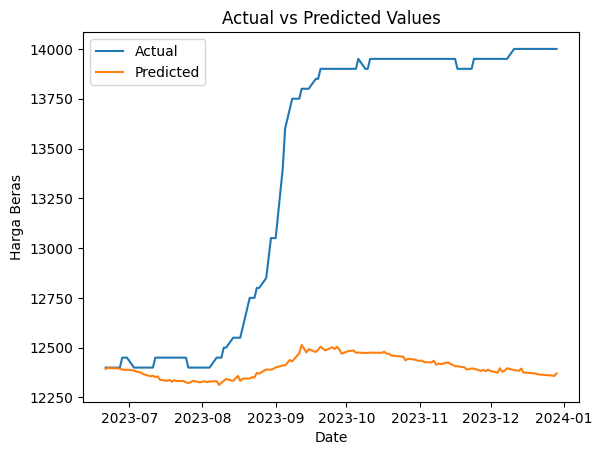

In [25]:
predict_no_decomp = data_modelling(train_data_asli, test_data_asli)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(predict_no_decomp,test_data_asli['Harga Beras'].values))
mae = mean_absolute_error(predict_no_decomp,test_data_asli['Harga Beras'].values)
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

# R Square
r = r2_score(predict_no_decomp,test_data_asli['Harga Beras'].values)

# Mean Magnitude of Relative Error
mmre = (abs((predict_no_decomp - test_data_asli['Harga Beras'].values) / test_data_asli['Harga Beras'].values)).mean()

# Median Magnitude of Relative Error
mdmre = np.median(abs((predict_no_decomp - test_data_asli['Harga Beras'].values) / test_data_asli['Harga Beras'].values))

# Mean Magnitude of Error Relative
mmer = (abs(predict_no_decomp - test_data_asli['Harga Beras'].values)).mean()

# Mean Square Error
mse = mean_squared_error(predict_no_decomp, test_data_asli['Harga Beras'].values)

# Menampilkan hasil
print("R Square: {:.4f}".format(r))
print("Mean Magnitude of Relative Error: {:.4f}".format(mmre))
print("Median Magnitude of Relative Error: {:.4f}".format(mdmre))
print("Mean Magnitude of Error Relative: ", mmer)
print("Mean Square Error:", mse)

Root Mean Square Error: 1171.1956605912935
Mean Absolute Error: 970.0602999824852
R Square: -477.0920
Mean Magnitude of Relative Error: 0.0701
Median Magnitude of Relative Error: 0.1008
Mean Magnitude of Error Relative:  970.0602999824852
Mean Square Error: 1371699.2753878762
